<a href="https://colab.research.google.com/github/AnaBarb0sa/traducao_automatica-Ana-Goes/blob/main/Traducao_Automatica_Ana_Goes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip -q install torchtext==0.17.2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 24.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 755.5/755.5 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 112.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 90.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 44.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸━━━━━ 105.9/121.6 MB 142.5 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
!pip install requests

In [ ]:
import math
import os
import re
import time
import random
import zipfile
import urllib.request
from collections import Counter
from typing import List, Tuple, Dict


import torch
import torch.nn as nn
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

In [ ]:
import os, zipfile, time, random, re, urllib.request, urllib.error, requests

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
SEED = 42
random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
  torch.cuda.manual_seed_all(SEED)

In [ ]:
class Timer:
  def __init__(self):
    self.t0 = time.time()

  def reset(self):
    self.t0 = time.time()

  def elapsed(self):
    return time.time() - self.t0

In [ ]:
## Hiperparametros

HYPERPARAMS = {
"num_examples": 12000, # altere para 600, 12000, 50000, etc. (Exercício 9.5.7.1)
"num_steps": 10,
"min_freq": 2,
"batch_size": 128,
"embed_size": 256,
"hidden_size": 512,
"num_layers": 1,
"dropout": 0.1,
"lr": 2e-3,
"num_epochs": 5,
}


DATA_DIR = "./data_tatoeba"
os.makedirs(DATA_DIR, exist_ok=True)

## Download & Pré-processamento (Tatoeba EN–FR)


In [ ]:
DATA_DIR = "./data_tatoeba"
os.makedirs(DATA_DIR, exist_ok=True)

URL = "https://www.manythings.org/anki/fra-eng.zip"
ZIP_PATH = os.path.join(DATA_DIR, "fra-eng.zip")
TXT_PATH = os.path.join(DATA_DIR, "fra.txt")

def _download_with_headers(url, dst, max_retries=3):
    # 1) tenta com requests + headers de navegador
    headers = {
        "User-Agent": "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 "
                      "(KHTML, like Gecko) Chrome/120.0 Safari/537.36",
        "Accept": "*/*",
        "Accept-Language": "en-US,en;q=0.9",
    }
    for i in range(max_retries):
        try:
            with requests.get(url, headers=headers, stream=True, timeout=30) as r:
                r.raise_for_status()
                with open(dst, "wb") as f:
                    for chunk in r.iter_content(chunk_size=8192):
                        if chunk:
                            f.write(chunk)
            return
        except Exception as e:
            if i == max_retries - 1:
                raise
            time.sleep(1.5 * (i + 1))

if not os.path.exists(TXT_PATH):
    if not os.path.exists(ZIP_PATH):
        print("Baixando (com headers):", URL)
        _download_with_headers(URL, ZIP_PATH)
    with zipfile.ZipFile(ZIP_PATH, "r") as zf:
        zf.extractall(DATA_DIR)
    print("Extraído para:", DATA_DIR)

Baixando (com headers): https://www.manythings.org/anki/fra-eng.zip
Extraído para: ./data_tatoeba


In [ ]:
# --- Ler fra.txt e construir 'pairs' (EN, FR) ---
def normalize_text(s: str) -> str:
    s = s.strip().lower()
    s = re.sub(r"([,.!?;:\(\)\"'])", r" \1 ", s)
    s = re.sub(r"\s+", " ", s)
    return s

pairs = []
with open(TXT_PATH, encoding="utf-8") as f:
    for line in f:
        # cada linha: EN \t FR \t (metadados opcionais)
        cols = line.rstrip("\n").split("\t")
        if len(cols) >= 2:
            eng = normalize_text(cols[0])
            fra = normalize_text(cols[1])
            if eng and fra:
                pairs.append((eng, fra))

random.shuffle(pairs)
orig_size = len(pairs)
pairs = pairs[: HYPERPARAMS["num_examples"]]
print(f"Pares carregados: {len(pairs)} (de {orig_size})")
print("Exemplo:", pairs[0])


Pares carregados: 12000 (de 237838)
Exemplo: ('tom made many mistakes . ', 'tom a fait beaucoup de fautes . ')


## Tokenização & Vocabulários

Divide em tokens por espaço (word-level), acrescenta tokens especiais e constrói vocabulários com `min_freq`. Mantemos `<pad>`, `<bos>`, `<eos>`, `<unk>`.

In [ ]:
SPECIAL_TOKENS = ["<pad>", "<bos>", "<eos>", "<unk>"]
PAD, BOS, EOS, UNK = SPECIAL_TOKENS


def tokenize(s: str) -> List[str]:
    return s.split(" ")


def build_vocab(texts: List[List[str]], min_freq: int) -> Tuple[Dict[str, int], Dict[int, str]]:
    counter = Counter()
    for t in texts:
        counter.update(t)
    itos = list(SPECIAL_TOKENS)
    for tok, freq in counter.most_common():
        if freq >= min_freq and tok not in SPECIAL_TOKENS:
            itos.append(tok)
    stoi = {tok: i for i, tok in enumerate(itos)}
    return stoi, {i: tok for tok, i in stoi.items()}

eng_tokens = [tokenize(e) for e, _ in pairs]
fra_tokens = [tokenize(f) for _, f in pairs]

eng_stoi, eng_itos = build_vocab(eng_tokens, HYPERPARAMS["min_freq"])
fra_stoi, fra_itos = build_vocab(fra_tokens, HYPERPARAMS["min_freq"])

print(f"|V_en| = {len(eng_stoi)} |V_fr| = {len(fra_stoi)}")

|V_en| = 2744 |V_fr| = 3552


## Dataset, Truncamento & Padding

Converte listas de tokens para IDs, aplica `<bos>`/`<eos>`, trunca/pad para `num_steps` e monta `DataLoader` com máscaras de comprimento válidas.


In [ ]:
def encode(tokens: List[str], stoi: Dict[str, int]) -> List[int]:
    ids = [stoi.get(tok, eng_stoi[UNK] if stoi is eng_stoi else fra_stoi[UNK]) for tok in tokens]
    return ids


def to_tensor(seq: List[int], num_steps: int, pad_id: int) -> torch.Tensor:
    seq = [eng_stoi[BOS] if pad_id == eng_stoi[PAD] else fra_stoi[BOS]] + seq + [eng_stoi[EOS] if pad_id == eng_stoi[PAD] else fra_stoi[EOS]]
    seq = seq[: num_steps]
    if len(seq) < num_steps:
        seq = seq + [pad_id] * (num_steps - len(seq))
    return torch.tensor(seq, dtype=torch.long)

class NMTDataset(Dataset):
    def __init__(self, pairs, num_steps):
        self.pairs = pairs
        self.num_steps = num_steps
    def __len__(self):
        return len(self.pairs)
    def __getitem__(self, idx):
        en, fr = self.pairs[idx]
        en_ids = encode(tokenize(en), eng_stoi)
        fr_ids = encode(tokenize(fr), fra_stoi)
        src = to_tensor(en_ids, self.num_steps, eng_stoi[PAD])
        tgt = to_tensor(fr_ids, self.num_steps, fra_stoi[PAD])
        # comprimentos válidos (até antes de <pad>)
        src_valid = (src != eng_stoi[PAD]).sum()
        tgt_valid = (tgt != fra_stoi[PAD]).sum()
        return src, src_valid, tgt, tgt_valid

train_ds = NMTDataset(pairs, HYPERPARAMS["num_steps"])
train_iter = DataLoader(train_ds, batch_size=HYPERPARAMS["batch_size"], shuffle=True)


## Modelo Seq2Seq (Encoder–Decoder GRU)

Implementação de um Encoder e Decoder com GRU. Embeddings independentes por idioma, e *teacher forcing* durante o treino. Decodificação greedy para inferência.



In [ ]:
class Encoder(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, num_layers=1, dropout=0.0):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, embed_size, padding_idx=0)
        self.rnn = nn.GRU(embed_size, hidden_size, num_layers=num_layers, batch_first=True, dropout=dropout if num_layers > 1 else 0.0)
    def forward(self, x, lengths):
        emb = self.embed(x)
        packed_out, h = self.rnn(emb)
        return h  # [num_layers, B, H]

class Decoder(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, num_layers=1, dropout=0.0):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, embed_size, padding_idx=0)
        self.rnn = nn.GRU(embed_size, hidden_size, num_layers=num_layers, batch_first=True, dropout=dropout if num_layers > 1 else 0.0)
        self.fc = nn.Linear(hidden_size, vocab_size)
    def forward(self, y_prev, h):
        emb = self.embed(y_prev)
        out, h = self.rnn(emb, h)
        logits = self.fc(out)
        return logits, h

class Seq2Seq(nn.Module):
    def __init__(self, enc, dec):
        super().__init__()
        self.enc = enc
        self.dec = dec
    def forward(self, src, tgt):
        # tgt inclui <bos> e <eos>, treinamos para prever próxima palavra
        h = self.enc(src, (src != eng_stoi[PAD]).sum(dim=1))
        # y_in: tudo menos o último token
        y_in = tgt[:, :-1]
        y_out = tgt[:, 1:]
        logits, _ = self.dec(y_in, h)
        return logits, y_out

enc = Encoder(len(eng_stoi), HYPERPARAMS["embed_size"], HYPERPARAMS["hidden_size"], HYPERPARAMS["num_layers"], HYPERPARAMS["dropout"]).to(device)
dec = Decoder(len(fra_stoi), HYPERPARAMS["embed_size"], HYPERPARAMS["hidden_size"], HYPERPARAMS["num_layers"], HYPERPARAMS["dropout"]).to(device)
model = Seq2Seq(enc, dec).to(device)

criterion = nn.CrossEntropyLoss(ignore_index=fra_stoi[PAD])
optimizer = torch.optim.AdamW(model.parameters(), lr=HYPERPARAMS["lr"])


## Curvas de Treinamento (Loss & Perplexity)


Registramos o histórico de loss/token e perplexity por época para visualizar o aprendizado do seq2seq.


In [ ]:
train_loss_hist, train_ppl_hist = [], []

for epoch in range(1, HYPERPARAMS["num_epochs"] + 1):
    model.train()
    t = Timer()
    total_loss, total_tokens = 0.0, 0

    for src, src_len, tgt, tgt_len in train_iter:
        src = src.to(device)
        tgt = tgt.to(device)

        optimizer.zero_grad()
        logits, y_out = model(src, tgt)
        loss = criterion(logits.reshape(-1, logits.size(-1)), y_out.reshape(-1))
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        ntokens = (y_out != fra_stoi[PAD]).sum().item()
        total_loss += loss.item() * ntokens
        total_tokens += ntokens

    loss_per_tok = total_loss / max(1, total_tokens)
    ppl = math.exp(loss_per_tok)
    train_loss_hist.append(loss_per_tok)
    train_ppl_hist.append(ppl)
    print(f"Epoch {epoch} | loss/token={loss_per_tok:.4f} | ppl≈{ppl:.2f} | time={t.elapsed():.1f}s")

Epoch 1 | loss/token=3.9618 | ppl≈52.55 | time=57.8s
Epoch 2 | loss/token=2.6767 | ppl≈14.54 | time=58.0s
Epoch 3 | loss/token=2.0967 | ppl≈8.14 | time=57.1s
Epoch 4 | loss/token=1.6342 | ppl≈5.13 | time=58.0s
Epoch 5 | loss/token=1.2356 | ppl≈3.44 | time=56.7s


In [ ]:
@torch.no_grad()
def greedy_translate(eng_sentence: str, max_len: int = 20) -> str:
    model.eval()
    src = to_tensor(encode(tokenize(normalize_text(eng_sentence)), eng_stoi), HYPERPARAMS["num_steps"], eng_stoi[PAD]).unsqueeze(0).to(device)
    h = model.enc(src, None)
    y = torch.tensor([[fra_stoi[BOS]]], dtype=torch.long, device=device)
    out_tokens = []
    for _ in range(max_len):
        logits, h = model.dec(y, h)
        next_id = logits[:, -1, :].argmax(dim=-1)
        token_id = next_id.item()
        if token_id == fra_stoi[EOS]:
            break
        out_tokens.append(fra_itos.get(token_id, UNK))
        y = torch.cat([y, next_id.unsqueeze(1)], dim=1)
    return " ".join(out_tokens)

# exemplos
examples = [
    "i love you !",
    "this is a test .",
    "where is the bathroom ?",
]
for s in examples:
    print(s, "->", greedy_translate(s))


i love you ! -> je vous en prie . 
this is a test . -> c ' est une histoire . 
where is the bathroom ? -> où se trouve la gare ? 


In [ ]:
# Reexecuta pipeline de vocabulário com diferentes amostras e imprime |V_en| e |V_fr|.

sizes_to_try = [600, 12000, 50000]
for k in sizes_to_try:
    sample = pairs[:k] if k <= len(pairs) else pairs
    eng_toks = [tokenize(e) for e, _ in sample]
    fr_toks = [tokenize(f) for _, f in sample]
    en_stoi_k, _ = build_vocab(eng_toks, HYPERPARAMS["min_freq"])
    fr_stoi_k, _ = build_vocab(fr_toks, HYPERPARAMS["min_freq"])
    print(f"num_examples={len(sample):>6} |V_en|={len(en_stoi_k):>6} |V_fr|={len(fr_stoi_k):>6}")

num_examples=   600 |V_en|=   359 |V_fr|=   390
num_examples= 12000 |V_en|=  2744 |V_fr|=  3552
num_examples= 12000 |V_en|=  2744 |V_fr|=  3552


## Gráficos para visualização do modelo

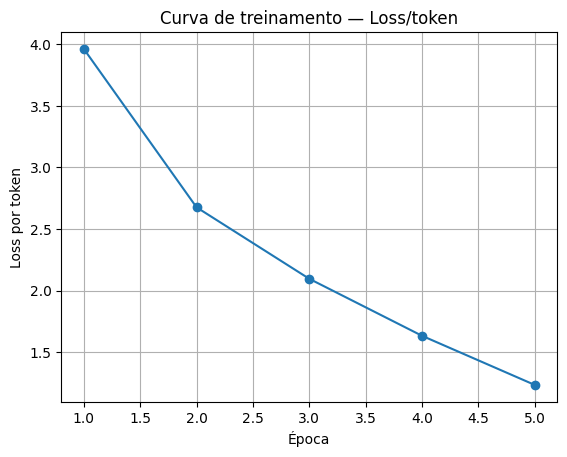

In [ ]:
# Loss/token por época

plt.figure()
plt.plot(range(1, len(train_loss_hist)+1), train_loss_hist, marker="o")
plt.xlabel("Época")
plt.ylabel("Loss por token")
plt.title("Curva de treinamento — Loss/token")
plt.grid(True)
plt.show()


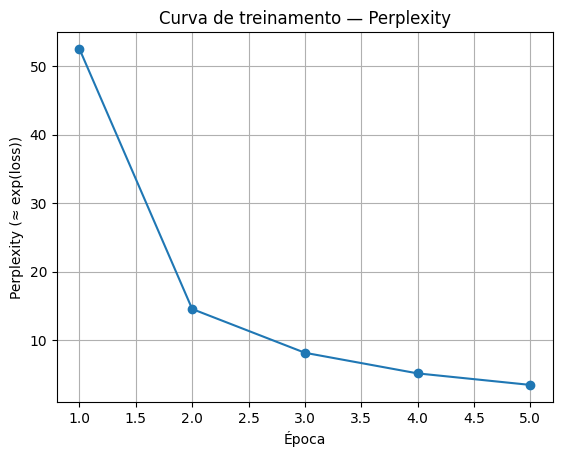

In [ ]:
# Perplexity por época

plt.figure()
plt.plot(range(1, len(train_ppl_hist)+1), train_ppl_hist, marker="o")
plt.xlabel("Época")
plt.ylabel("Perplexity (≈ exp(loss))")
plt.title("Curva de treinamento — Perplexity")
plt.grid(True)
plt.show()